# Lesson 5 Assignment

In this lab assignment, you will build a non-tree-based classifier where you can ensemble any base-learners and pass it to the using a BaggingClassifier or any of the other ensemble learners in sklearn.ensemble.

In [1]:
# import packages
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

# make this notebook's output stable across runs
np.random.seed(0)

## Data Set Information:

This dataset represents a set of possible advertisements on Internet pages. The features encode the geometry of the image (if available) as well as phrases occuring in the URL, the image's URL and alt text, the anchor text, and words occuring near the anchor text. The task is to predict whether an image is an advertisement ("ad") or not ("nonad"). Additional information can be found [here](https://archive.ics.uci.edu/ml/datasets/internet%2Badvertisements).

## Attribute Information:

The dataset has 3 continous (height, width, aratio) and 1555 binary (urls, tags, captions) features. 

## Source:

Creator & donor: Nicholas Kushmerick <nick '@' ucd.ie>

In [2]:
# Load the data
internetAd = pd.read_csv('Internet_Ad_Data.csv', sep=',', on_bad_lines='skip') # removing error_on_lines as it's deprecated
print(internetAd.info())
internetAd.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3279 entries, 0 to 3278
Columns: 1559 entries, height to Target
dtypes: int64(1554), object(5)
memory usage: 39.0+ MB
None


/var/folders/xy/h3yp80md61v6ctklz0msf9300000gn/T/ipykernel_2135/254514623.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  internetAd = pd.read_csv('Internet_Ad_Data.csv', sep=',', on_bad_lines='skip') # removing error_on_lines as it's deprecated


,height,width,aratio,local,url*images+buttons,url*likesbooks.com,url*www.slake.com,url*hydrogeologist,url*oso,url*media,...,caption*home,caption*my,caption*your,caption*in,caption*bytes,caption*here,caption*click,caption*for,caption*you,Target
0,125,125,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
1,57,468,8.2105,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
2,33,230,6.9696,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
3,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
4,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.


Question 1: Prepare and impute missing values with the median

In [3]:
# Strip white spaces before and after each string in all string columns
for column in internetAd:
    if(internetAd[column].dtype == object):
        internetAd[column] = internetAd[column].str.strip()

# Replacing ? with np.NaN
internetAd.replace('?', np.NaN, inplace=True)

In [4]:
# Converting object columns to float columns to be able to calculate median
internetAd['height'] = internetAd['height'].astype(float)
internetAd['width'] = internetAd['width'].astype(float)
internetAd['aratio'] = internetAd['aratio'].astype(float)
internetAd['local'] = internetAd['local'].astype(float)

# Replacing NaN's with median using fillna()
internetAd['height'].fillna(internetAd['height'].median(), inplace=True)
internetAd['width'].fillna(internetAd['width'].median(), inplace=True)
internetAd['local'].fillna(internetAd['local'].median(), inplace=True)
internetAd['aratio'].fillna(internetAd['aratio'].median(), inplace=True)

# Replacing ad and nonad with 1 and 0
# internetAd['Target'].unique()
internetAd['Target'] = internetAd['Target'].map({'ad.': 1, 'nonad.': 0})

In [5]:
# Checking for null values in columns: there should not be any null values
res = internetAd.isnull().sum()
res[res > 0]

Series([], dtype: int64)

Question 2: Split dataset into training and test set

In [6]:
from sklearn.model_selection import train_test_split

X = internetAd.iloc[:,:-1]
y = internetAd.iloc[:,-1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
# Scaling data using minmax scaler. Not using standard scaler because I don't want to change data distribution
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_minmax_np = scaler.fit_transform(X_train)
X_test_minmax_np = scaler.transform(X_test)
X_train_minmax_scaled = pd.DataFrame(X_train_minmax_np, index=X_train.index, columns=X_train.columns)
X_test_minmax_scaled = pd.DataFrame(X_test_minmax_np, index=X_test.index, columns=X_test.columns)

Question 3: Train and evaluate a LogisticRegression classifier using LogisticRegression.

In [8]:
dtc_grid = LogisticRegression()
dtc_grid.fit(X_train_minmax_scaled, y_train.values.ravel())

LogisticRegression()

In [9]:
# make predictions with the trained logistic regression
test_z = dtc_grid.predict(X_test_minmax_scaled)
test_z_prob = dtc_grid.predict_proba(X_test_minmax_scaled)

# evaluate the model performance - AUC and ROC
lr_acc = accuracy_score(y_test, test_z)
print("Accuracy for Random Forest:", lr_acc)
lr_ras = roc_auc_score(y_test, test_z)
print("ROC-AUC score for Random Forest:", lr_ras)

Accuracy for Random Forest: 0.9695290858725761
ROC-AUC score for Random Forest: 0.90854208613341


Question 4: Use BaggingClassifier to train and evaluate an ensemble model of LogisticRegression  base classifiers. Each base classifier should be trained only on a sample half the size of the training data, and using only half as many features as there are in in total the training data (read the documentation for the function to see how to do this).

In [10]:
max_samples = int(X_train.shape[0]/2)
max_features = int(X_train.shape[1]/2)

In [11]:
bagOLR = BaggingClassifier(base_estimator=LogisticRegression(), random_state=0, max_samples=max_samples, max_features=max_features, n_estimators=10)
bagOLR.fit(X_train_minmax_scaled, y_train.values.ravel())

BaggingClassifier(base_estimator=LogisticRegression(), max_features=779,
                  max_samples=1098, random_state=0)

In [12]:
# make predictions with the trained random forest
test_z = bagOLR.predict(X_test_minmax_scaled)
test_z_prob = bagOLR.predict_proba(X_test_minmax_scaled)

# evaluate the model performance - AUC and ROC
bc_acc = accuracy_score(y_test, test_z)
print("Accuracy for Random Forest:", bc_acc)
bc_ras = roc_auc_score(y_test, test_z)
print("ROC-AUC score for Random Forest:", bc_ras)

Accuracy for Random Forest: 0.9566020313942751
ROC-AUC score for Random Forest: 0.8666259184687394


Question 5: Use AdaBoostClassifier to train and evaluate an ensemble model of LogisticRegression base classifiers.

In [13]:
boostOkLR = AdaBoostClassifier(n_estimators=100, random_state=0)
boostOkLR.fit(X_train_minmax_scaled, y_train.values.ravel())

AdaBoostClassifier(n_estimators=100, random_state=0)

In [14]:
# make predictions with the trained random forest
test_z = boostOkLR.predict(X_test_minmax_scaled)
test_z_prob = boostOkLR.predict_proba(X_test_minmax_scaled)

# evaluate the model performance - AUC and ROC
ab_acc = accuracy_score(y_test, test_z)
print("Accuracy for Random Forest:", ab_acc)
ab_ras = roc_auc_score(y_test, test_z)
print("ROC-AUC score for Random Forest:", ab_ras)

Accuracy for Random Forest: 0.9667590027700831
ROC-AUC score for Random Forest: 0.9093526919959208


[Bonus] Question 6: Use StackingClassifier to train and evaluate an ensemble model of LogisticRegression base classifiers. to get better accuracy than previous classifiers.

In [18]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

estimators = [('lr1', LogisticRegression()),
              ('lr2', LogisticRegression()),
              ('lr3', LogisticRegression()),
              ('lr4', LogisticRegression()),
              ('lr5', LogisticRegression())]

parameters = {
    "final_estimator": [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier()],
    "cv": [None, 3, 7],
    "stack_method": ['auto', 'predict', 'predict_proba', 'decision_function'],
    "passthrough": [True, False]
}

clf = StackingClassifier(estimators=estimators)
    
dtc_grid = GridSearchCV(estimator = clf, param_grid = parameters, return_train_score = True)
dtc_grid.fit(X_train_minmax_scaled, y_train.values.ravel())

GridSearchCV(estimator=StackingClassifier(estimators=[('lr1',
                                                       LogisticRegression()),
                                                      ('lr2',
                                                       LogisticRegression()),
                                                      ('lr3',
                                                       LogisticRegression()),
                                                      ('lr4',
                                                       LogisticRegression()),
                                                      ('lr5',
                                                       LogisticRegression())]),
             param_grid={'cv': [None, 3, 7],
                         'final_estimator': [LogisticRegression(),
                                             RandomForestClassifier(),
                                             GradientBoostingClassifier()],
                         'passthrough':

In [20]:
dtc_grid.best_params_

{'cv': 3,
 'final_estimator': RandomForestClassifier(),
 'passthrough': True,
 'stack_method': 'decision_function'}

In [21]:
stack_clf = StackingClassifier(estimators=estimators, cv=3, final_estimator=RandomForestClassifier(), passthrough=True, stack_method='decision_function')
stack_clf.fit(X_train_minmax_scaled, y_train.values.ravel())

StackingClassifier(cv=3,
                   estimators=[('lr1', LogisticRegression()),
                               ('lr2', LogisticRegression()),
                               ('lr3', LogisticRegression()),
                               ('lr4', LogisticRegression()),
                               ('lr5', LogisticRegression())],
                   final_estimator=RandomForestClassifier(), passthrough=True,
                   stack_method='decision_function')

In [22]:
# make predictions with the trained random forest
test_z = stack_clf.predict(X_test_minmax_scaled)
test_z_prob = stack_clf.predict_proba(X_test_minmax_scaled)

# evaluate the model performance - AUC and ROC
sc_acc = accuracy_score(y_test, test_z)
print("Accuracy for Random Forest:", sc_acc)
sc_ras = roc_auc_score(y_test, test_z)
print("ROC-AUC score for Random Forest:", sc_ras)

Accuracy for Random Forest: 0.9704524469067405
ROC-AUC score for Random Forest: 0.9286732212431034


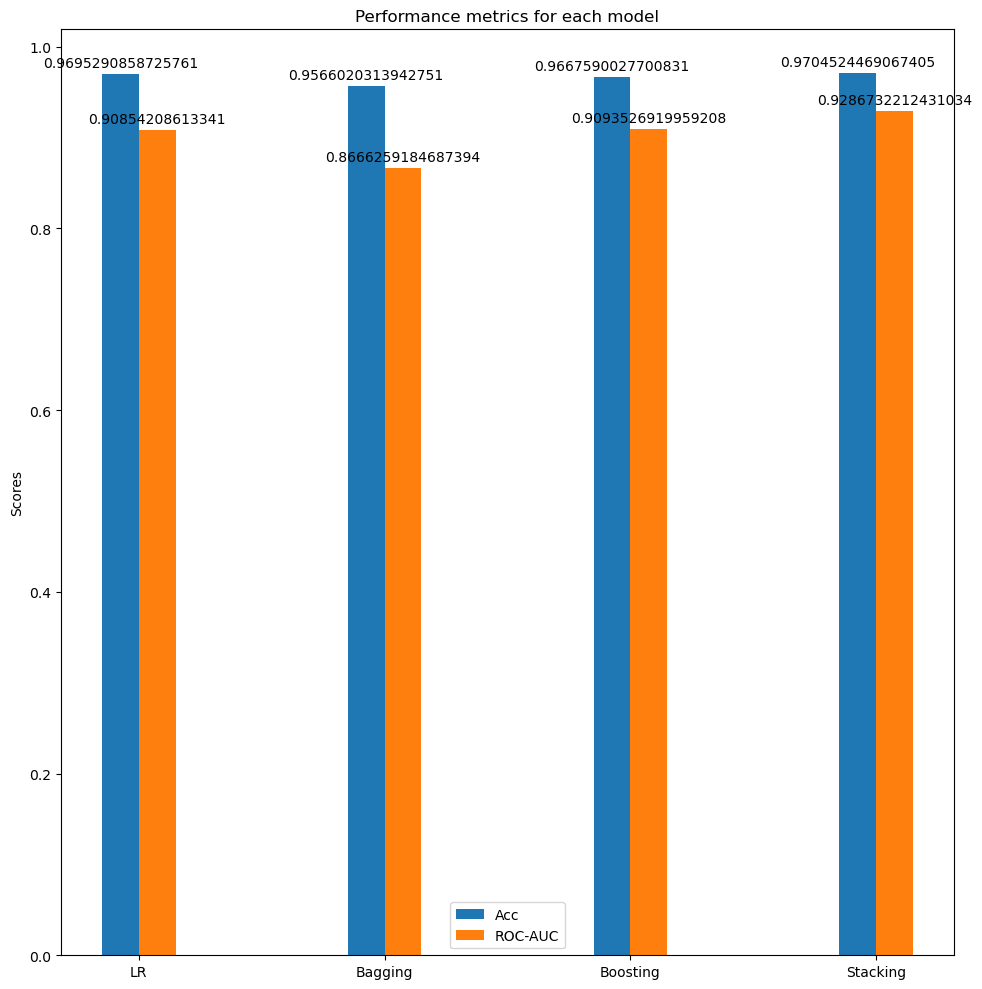

In [25]:
# Compare performance
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 100

models = ("LR", "Bagging", "Boosting", "Stacking")
accuracy = [lr_acc, bc_acc, ab_acc, sc_acc]
roc_auc = [lr_ras, bc_ras, ab_ras, sc_ras]

x = np.arange(len(models))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, accuracy, width, label='Acc')
rects2 = ax.bar(x + width/2, roc_auc, width, label='ROC-AUC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Performance metrics for each model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

Question 7: Create a new text cell in your Notebook: Complete a 50-100 word summary (or short description of your thinking in applying this week's learning to the solution) of your experience in this assignment. Include: What was your incoming experience with this model, if any? what steps you took, what obstacles you encountered. how you link this exercise to real-world, machine learning problem-solving. (What steps were missing? What else do you need to learn?) This summary allows your instructor to know how you are doing and allot points for your effort in thinking and planning, and making connections to real-world work.

Incoming experience: No incoming experience apart from previous assignments.

Steps taken: This week's lesson was about stacking and blending. Got a feel for how metrics can be improved with stacking.

Obstacles: Wasn't very hard to figure out the assignment this week.

Link to real world: Helped me understand when Scikit learn libraries and how they can be leveraged.

Steps missing (with just this week's learning): Scaling and hyperparameter tuning.